#Scripts de PyPlot para hacer las figuras *à la Journ. NeuroSciences*...

Primero, vamos a intentarlo con un experimento que tenga una actividad notoria. Aquí cargamos un archivo que contiene los datos de un experimento con actividad epiléptica. La región CA aparece muy activa varias veces en las mediciones del potencial de campo local, LFP de ahora en adelante.

In [4]:
using PyPlot

INFO: Loading help data...


In [5]:
ParaMostrar=readdlm("EjemploPlaticaCrudo01.dat");
size(ParaMostrar)

(1001,1)

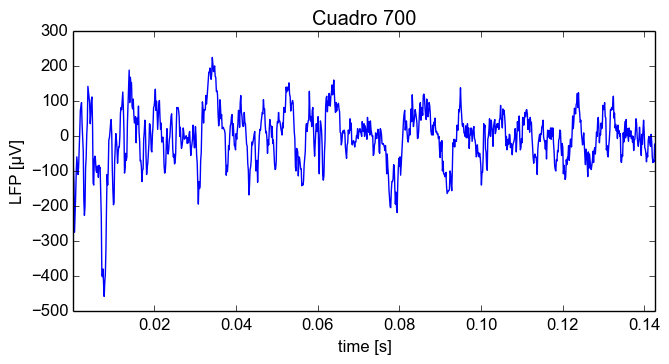

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc95d782f10>

In [6]:
tiempo=1:1001
t=700
tit="Cuadro $t"
figure(figsize=(7.5,3.5))
PyPlot.xlim(1/7022,1001/7022)
xlabel("time [s]")
ylabel("LFP [µV]")
title(tit)
plot(tiempo/7022,ParaMostrar)

In [7]:
ParaMostrarSuave=readdlm("EjemploPlaticaSuave01.dat");

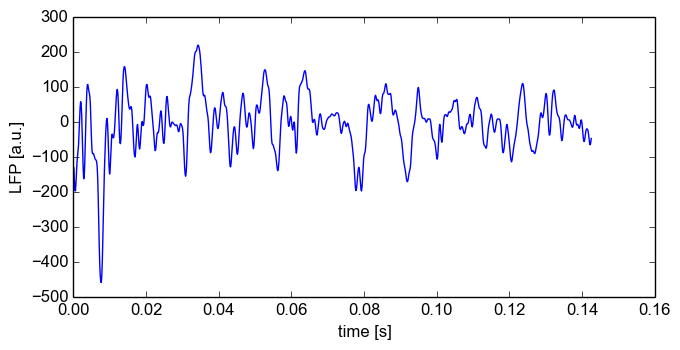

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc954d44c50>

In [8]:
tiempo=1:1001
figure(figsize=(7.5,3.5))
xlabel("time [s]")
ylabel("LFP [a.u.]")
plot(tiempo/7022,ParaMostrarSuave)

In [46]:
PyPlot.rc(font1)  #esto que?

In [9]:
t=700
EjemploCentrosCSDPos=readdlm("GarbageCollector/CMPosLapla-$t.dat")
xxpos=EjemploCentrosCSDPos[:,1]
yypos=EjemploCentrosCSDPos[:,2]
valorpos=EjemploCentrosCSDPos[:,3]
EjemploCentrosCSDNeg=readdlm("GarbageCollector/CMNegLapla-$t.dat")
xxneg=EjemploCentrosCSDNeg[:,1]
yyneg=EjemploCentrosCSDNeg[:,2]
valorneg=EjemploCentrosCSDNeg[:,3];
CSDEjemplo=readdlm("GarbageCollector/CSD-$t.dat");

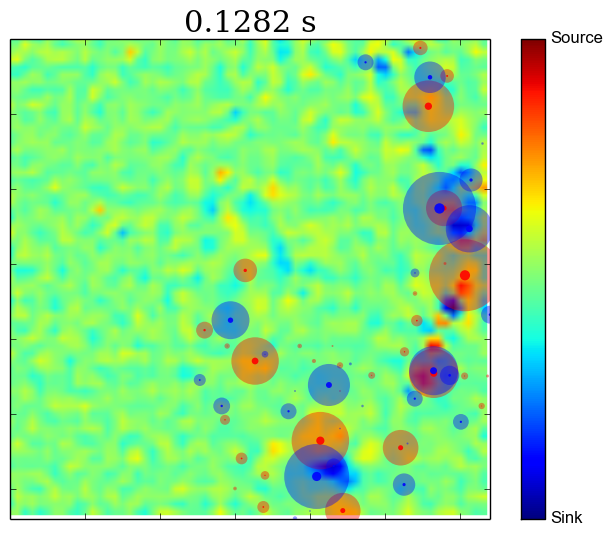

false

In [26]:
PyPlot.ion()
#################
font1 = ["family"=>"serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>22]
seg=round(t/7022, 4)
titulo="$seg s"
figure()
PyPlot.xlim(0,64)
PyPlot.ylim(64,0)
tick_params(labelbottom="off", labelleft="off")
otraimagen=imshow(CSDEjemplo, cmap="jet", origin="upper", vmin=-150, vmax=150)
#cb=colorbar(otraimagen)
#cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04, use_gridspace='True')
cb=colorbar(otraimagen, ticks=[-150, +150], use_gridspec="True")
farofa=cb[:set_ticklabels]([{"Sink"}, {"Source"}])
#xlabel("furufu", fontdict=font1)
scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r", edgecolors="none")
scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="b", edgecolors="none")
scatter(xxpos,yypos, s=0.02*valorpos, alpha=0.9, c="r", edgecolors="none")
scatter(xxneg, yyneg,s=0.02*abs(valorneg), alpha=0.9, c="b", edgecolors="none")

#annotate("Sink",
#    xy=[1.05;-0.11],
#    xycoords="axes fraction",
#    xytext=[-10,10],
#    textcoords="offset points",
# font_properties="serif",
#    fontsize=24.0,
#    ha="left",
#    va="bottom")

#annotate("Source",
#    xy=[1.05;0.98],
#    xycoords="axes fraction",
#    xytext=[-10,10],
#    textcoords="offset points",
#font_properties=("serif"),
#fontsize=24,
#ha="left",
#    va="bottom")

title(titulo, fontdict=font1)
 #tight_layout()
#savefig("CSD_nocb-$t.png", dpi=36)
PyPlot.close_queued_figs()

In [39]:
dedonde, adonde = 1, 3122
PyPlot.ioff()

In [41]:
@time for t=dedonde:adonde
    #read the data
    EjemploCentrosCSDPos=readdlm("GarbageCollector/CMPosLapla-$t.dat")
    xxpos=EjemploCentrosCSDPos[:,1]
    yypos=EjemploCentrosCSDPos[:,2]
    valorpos=EjemploCentrosCSDPos[:,3]
    EjemploCentrosCSDNeg=readdlm("GarbageCollector/CMNegLapla-$t.dat")
    xxneg=EjemploCentrosCSDNeg[:,1]
    yyneg=EjemploCentrosCSDNeg[:,2]
    valorneg=EjemploCentrosCSDNeg[:,3];
    CSDEjemplo=readdlm("GarbageCollector/CSD-$t.dat");
    #plot the data
    figure()
    seg=round(t/7022, 3)
    titulo="$seg s"
    PyPlot.xlim(0,64)
    PyPlot.ylim(64,0)
    
    otraimagen=imshow(CSDEjemplo, cmap="jet", origin="upper", vmin=-150, vmax=150)
    #cb=colorbar(otraimagen)
    cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04 )
    cb[:set_ticklabels]([{""}, {""}])
    
    
    annotate("Sink",
    xy=[1.05;-0.11],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=24.0,
    ha="left",
    va="bottom")

    annotate("Source",
    xy=[1.05;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=24.0,
    ha="left",
    va="bottom")

    
    scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r")
    scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="b")
    scatter(xxpos,yypos, s=0.01*valorpos, alpha=0.95, c="r", edgecolors="none")
    scatter(xxneg, yyneg,s=0.01*abs(valorneg), alpha=0.95, c="b", edgecolors="none")
    #plot(xxpos,yypos, "k+")
    #plot(xxneg, yyneg,"k+")

    title(titulo)
    savefig("GarbageCollector/CSD_CM_cb-$t.png", dpi=72)
    PyPlot.close_queued_figs()
    gc()
end

LoadError: PyError (:PyObject_Call) <type 'exceptions.ValueError'>
ValueError('setting an array element with a sequence.',)
  File "/usr/lib/pymodules/python2.7/matplotlib/pyplot.py", line 3087, in scatter
    linewidths=linewidths, verts=verts, **kwargs)
  File "/usr/lib/pymodules/python2.7/matplotlib/axes.py", line 6271, in scatter
    colors = mcolors.colorConverter.to_rgba_array(c, alpha)
  File "/usr/lib/pymodules/python2.7/matplotlib/colors.py", line 411, in to_rgba_array
    result[i] = self.to_rgba(cc, alpha)

while loading In[41], in expression starting on line 1

In [15]:
gc()

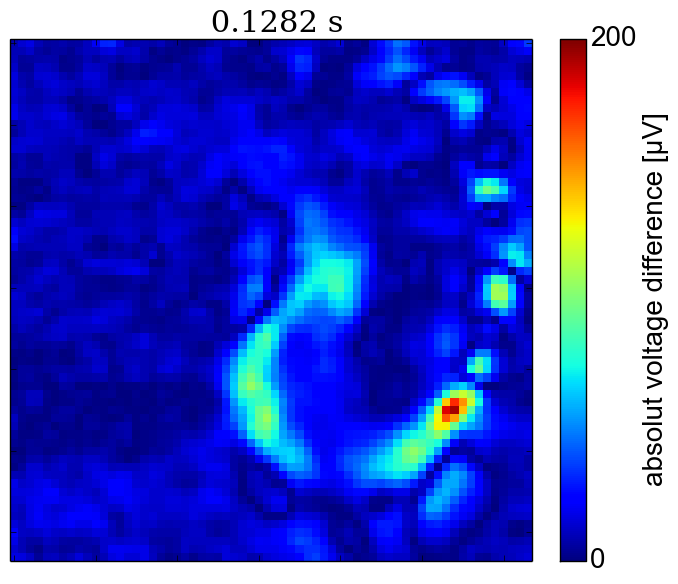

In [23]:
#guacala de jet. pero les gusta a los Journ. de Neurosc.
PyPlot.ion()
#for t=dedonde+10:adonde
t=900
lala=figure()
tick_params(labelbottom="off", labelleft="off")
b=round(t/7022, 4)
titulo=" $b s"
DatosSuaves=readdlm("GarbageCollector/LFPSuave-$t.dat")
imagen=imshow(abs(DatosSuaves), origin="upper", vmin=0, vmax=200, interpolation="none")
cb=colorbar(imagen, ticks=[-200, 0, +200],fraction=0.046, pad=0.04, use_gridspec="True" )
cb[:set_label]("absolut voltage difference [µV]  ", fontsize=20)
cb[:ax][:tick_params](labelsize=20)
title(titulo, fontdict=font1)
tight_layout()
savefig("AbsLFP_cb-$t.png", dpi=36)
PyPlot.close_queued_figs()
gc()
#end